In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def abs_sobel_thresh(gray, orient='x', thresh=(0, 255)):
    """Applies sobel filter and applies threshold.

    :param gray: A gray scale image.
    :param orient: Direction in which sobel filter is applied.
    :param thresh:  threshold to be applied on the output image.

    :return: a binary image after applying sobel

    """
    # check orientation to apply sobel in the direction.
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    sobel_mask = binary_output
    # Return the result
    return sobel_mask

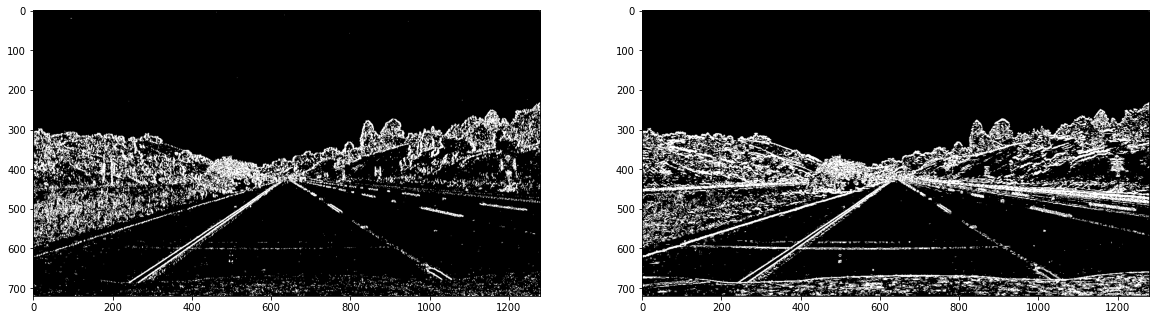

In [3]:
img = cv2.imread("./test_images/straight_lines1.jpg")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sobel_output_x = abs_sobel_thresh(gray,"x",(10,200))

sobel_output_y = abs_sobel_thresh(gray,"y",(10,200))

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1 = ax1.imshow(sobel_output_x,cmap="gray")
ax2 = ax2.imshow(sobel_output_y,cmap="gray")

In [4]:
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    """Applies sobel filter and calculates direction of gradient and applies a threshold.

    :param gray: A gray scale image.
    :param sobel_kernel: kernel size
    :param thresh: angle threshold to be applied on the output image.

    :return: a binary image after applying sobel and thresholding with an angle.

    """
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    dir_mask = binary_output
    # Return the binary image
    return dir_mask

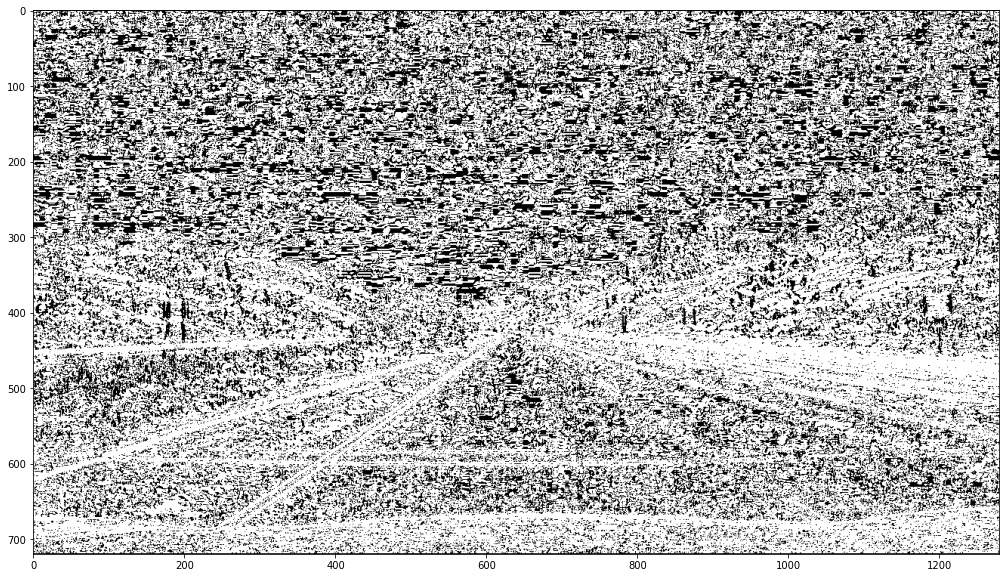

In [5]:
sobel_output_dir = dir_threshold(gray,3 ,(np.pi/6, np.pi/2))

f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1 = ax1.imshow(sobel_output_dir,cmap="gray")

In [6]:
def combine_thresh(img, s_thresh=(100, 255), l_thresh=(120, 255)):
    """Combines abs_sobel_thresh, dir_threshold and threshold on R, G, S and L channels to detect the lanes.

    :param img: An input RGB image.
    :param s_thresh: S channel threshold.
    :param l_thresh: L channel threshold.

    :return: a binary image after applying all different thresholds.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape

    grad_x = abs_sobel_thresh(gray, 'x', thresh=(10, 200))
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    combined = ((grad_x == 1) & (dir_binary == 1))

    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:, :, 0]
    G = img[:, :, 1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)

    # Apply color threshold for better detection of yello and white lines in all environmental condition
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Select S channel because it is usually the best performant
    # for this task. R channel also performs similarly.
    s_channel = hls[:, :, 2]
    l_channel = hls[:, :, 1]

    # S channel performs well for detecting bright yellow and white lanes
    s_condition = (s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])

    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_condition = (l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined)] = 1

    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0, height-1], [width/2, int(0.55*height)], [width-1, height-1]],
                                           dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)

    return thresholded

def thresholding(img):
    """An interface for combine_thresh.

    :param img: An input RGB image.

    :return: a binary image after applying all different thresholds.
    """

    thresholded = combine_thresh(img, s_thresh=(100, 255), l_thresh=(120, 255))
    return thresholded

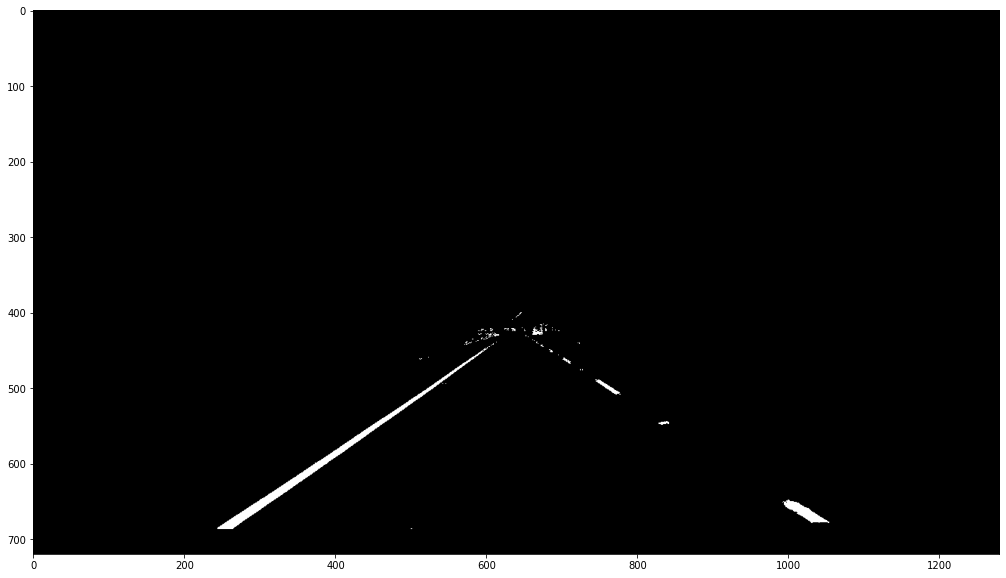

In [7]:
RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask_output = thresholding(RGB)

f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1 = ax1.imshow(mask_output,cmap="gray")

In [8]:
def perspective_warp(img,
                     dst_size=(1280, 720),
                     src=np.float32([(0.38, 0.7), (0.63, 0.7), (0.1, 1), (1, 1)]),
                     dst=np.float32([(0, 0), (1, 0), (0, 1), (1, 1)])):
    """Transforms the car view into bird eye view.

    :param img: An input RGB image.
    :param dst_size: destination image size.
    :param src: 4 points bounding the target area.
    :param dst: 4 points bounding the new position for the src points.

    :return: a bird eye view binary image.
    """
    img_size = np.float32([(img.shape[1], img.shape[0])])
    src = src * img_size
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result
    # again, not exact, but close enough for our purposes
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped


def inv_perspective_warp(img,
                         dst_size=(1280, 720),
                         src=np.float32([(0, 0), (1, 0), (0, 1), (1, 1)]),
                         dst=np.float32([(0.38, 0.7), (0.63, 0.7), (0.1, 1), (1, 1)])):
    """Transforms bird eye view back to the car view.

    :param img: An input RGB image.
    :param dst_size: destination image size.
    :param src: 4 points bounding the target area.
    :param dst: 4 points bounding the new position (original positions) for the src points.

    :return: a car view binary image.
    """

    img_size = np.float32([(img.shape[1], img.shape[0])])
    src = src * img_size
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result
    # again, not exact, but close enough for our purposes
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

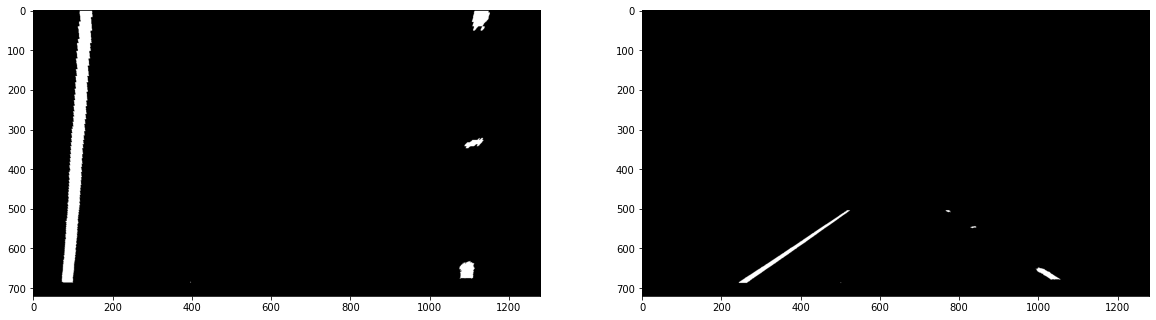

In [9]:
pw_output1 = perspective_warp(mask_output)

pw_output2 = inv_perspective_warp(pw_output1)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1 = ax1.imshow(pw_output1,cmap="gray")
ax2 = ax2.imshow(pw_output2,cmap="gray")

In [10]:
def get_hist(img):
    """returns a histogram that shows the concentration of white pixels in a certain column.

    :param img: binary image.
    :return: numpy array (histogram).
    """

    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

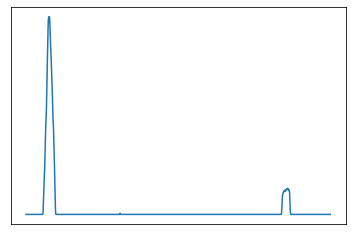

In [11]:
hist = get_hist(pw_output1)

x = np.array(range(0, 1280))

plt.plot(x, hist)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [14]:
left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]

def sliding_window(img, nwindows=9, margin=150, minpix=1, draw_windows=True):
    """Applies the sliding window search algorithm to fit a 2nd order curve to each lane.

    :param img: binary image.
    :param nwindows: number of windows per image.
    :param margin: half width of the window.
    :param minpix: min. number of white pixels per window to be accepted in deciding the next center.
    :param draw_windows: set to True or False to decide whether to draw the sliding windows on the output image or not.

    :return: bird view image with the pixels that belong to a lane colored.
    """
    global left_a, left_b, left_c, right_a, right_b, right_c
    left_fit_ = np.empty(3)
    right_fit_ = np.empty(3)

    out_img = np.dstack((img, img, img))*255

    histogram = get_hist(img)
    # find peaks of left and right halves
    quarter = int(histogram.shape[0]/4)
    leftx_base = np.argmax(histogram[:quarter])
    rightx_base = np.argmax(histogram[quarter*3:]) + quarter*3

    # Set height of windows
    window_height = int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_windows:
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),
            (100, 255, 255), 3)
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high),
            (100, 255, 255), 3)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds)  > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)  > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if(left_lane_inds.size > 1600) and (right_lane_inds.size > 1600):
        left_fit = np.polyfit(lefty, leftx, 2)
        left_a.append(left_fit[0])
        left_b.append(left_fit[1])
        left_c.append(left_fit[2])
        
        right_fit = np.polyfit(righty, rightx, 2)
        right_a.append(right_fit[0])
        right_b.append(right_fit[1])
        right_c.append(right_fit[2])

    else:
        left_a.append(left_a[-15])
        left_b.append(left_b[-15])
        left_c.append(left_c[-15])
        right_a.append(right_a[-15])
        right_b.append(right_b[-15])
        right_c.append(right_c[-15])

    
    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])
    left_fit_[2] = np.mean(left_c[-10:])
    
    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])
    right_fit_[2] = np.mean(right_c[-10:])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2]
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 100]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255]
    
    return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty


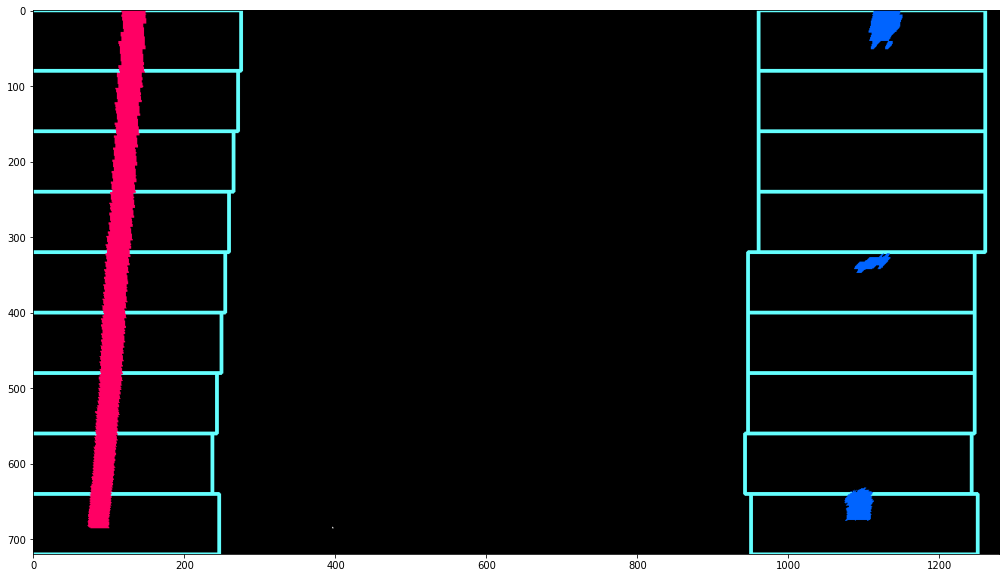

In [15]:
sw_output, curves, lanes, ploty = sliding_window(pw_output1, draw_windows=True)

f, (ax1) = plt.subplots(1,1, figsize=(20,10))
ax1 = ax1.imshow(sw_output)

In [16]:
def get_curve(img, leftx, rightx):
    """Calculates curvature of the two lane lines and the offset from center of the lane.
    :param img: original RGB image.
    :param leftx: numpy array to represent the left curve.
    :param rightx: numpy array to represent the right curve.

    :return: left line curvature, right line curvature, offset from center of the lane.
    """ 

    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 30.5 / 720 # meters per pixel in y dimension
    xm_per_pix = 3.7 / 720 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    car_pos = img.shape[1]/2
    
    l_fit_x_int = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center = (car_pos - lane_center_position) * xm_per_pix / 10
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad, center)

def draw_lanes(img, left_fit, right_fit):
    """Draws the lane on top of the original image.
    :param img: original RGB image.
    :param left_fit: numpy array to represent the left curve.
    :param right_fit: numpy array to represent the right curve.

    :return: output image where the lane is highlighted.
    """ 

    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    
    lane = np.zeros_like(img)

    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    points = np.hstack((left, right))
    
    cv2.fillPoly(color_img, np.int_(points), (0,200,255))

    cv2.polylines(lane, np.int32(left), False, color=(0,0,255), thickness=20)
    cv2.polylines(lane, np.int32(right), False, color=(255,0,0), thickness=20)

    inv_perspective = inv_perspective_warp(lane)
    output = cv2.addWeighted(inv_perspective, 1 , img, 1, 0)

    inv_perspective = inv_perspective_warp(color_img)
    output = cv2.addWeighted(inv_perspective, 1 , output, 1, 0)

    return output

In [17]:
curverad =get_curve(RGB, curves[0], curves[1])
lane_curve = np.mean([curverad[0], curverad[1]])
cur_output = draw_lanes(RGB, curves[0], curves[1])

f, (ax1) = plt.subplots(1,1, figsize=(20,10))
ax1 = ax1.imshow(cur_output)

TypeError: only size-1 arrays can be converted to Python scalars

In [17]:
debugging=0
def full_pipeline(img):
    th_img = thresholding(img)

    pew_img = perspective_warp(th_img)

    sw_img, curves, lanes, ploty = sliding_window(pew_img, draw_windows=True)

    curverad = get_curve(img, curves[0], curves[1])

    lane_curve = np.mean([curverad[0], curverad[1]])

    img = draw_lanes(img, curves[0], curves[1])
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize=0.5
    cv2.putText(img, 'Lane Curvature: {:.0f} m'.format(lane_curve), (570, 620), font, fontSize, fontColor, 2)
    cv2.putText(img, 'Vehicle offset: {:.4f} m'.format(curverad[2]), (570, 650), font, fontSize, fontColor, 2)
    
    if(debugging==0):
        final_img = img
    else:
        th_img_rgb = np.dstack((th_img,th_img,th_img))*255    
        pew_img_rgb = np.dstack((pew_img,pew_img,pew_img))*255
        
        img_row1 = np.concatenate((th_img_rgb, pew_img_rgb),axis = 0)
        img_row2 = np.concatenate((sw_img, img),axis = 0)

        final_img = np.concatenate((img_row1, img_row2),axis = 1)
        final_img = cv2.resize(final_img,(img.shape[1],img.shape[0]))

    return final_img

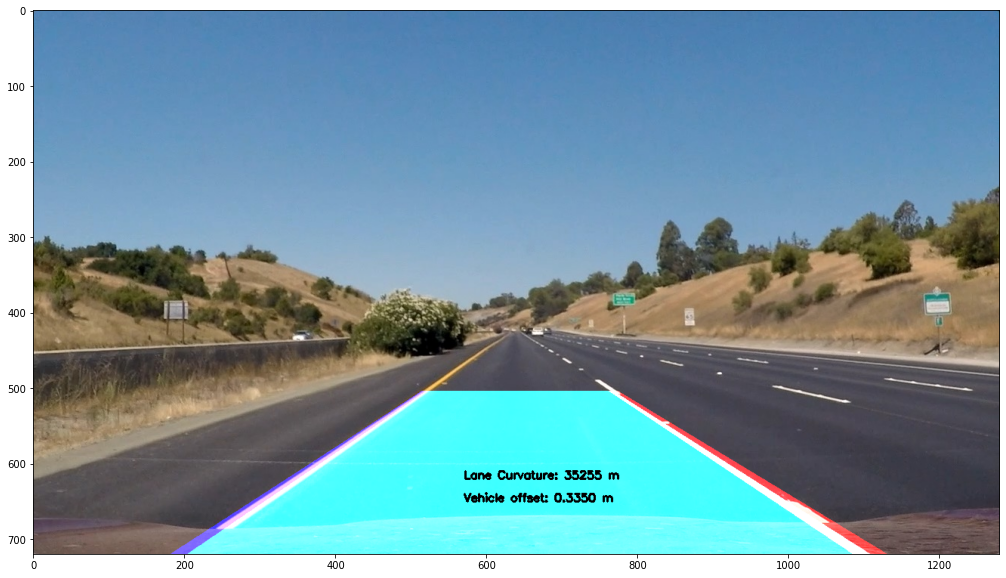

In [18]:
img = cv2.imread("./test_images/straight_lines1.jpg")

RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

output = full_pipeline(RGB)

f, (ax1) = plt.subplots(1,1, figsize=(20,10))
ax1 = ax1.imshow(output)